# Examples

We are going to use two examples to illustrate how to use Kulprit.

* In the body fat example the aim of the analysis is to predict an expensive and cumbersome water immersion measurement of body fat percentage (observed variable named `siri`) from a set of thirteen easier to measure characteristics, including `age`, `height`, `weight`, and circumferences of various body parts {cite}`Penrose_1985`. Can we reduce the number of predictors while maintaining predictive accuracy?

* In the bikes example we have a dataset containing the number of bike rentals per hour (`count`) in a bike-sharing system, along with several features that can be used to predict the number of rentals, including `temperature`, `windspeed`, `hour`, among others. Do we need all these predictors to make accurate predictions?

In [1]:
from arviz_plots import style
import bambi as bmb
import kulprit as kpt
import numpy as np
import pandas as pd

style.use("arviz-variat")
SEED = 9352
np.random.seed(SEED)

## Body Fat

The first thing we need to do is to load the data and define a model using Bambi. We are going to use a linear regression with Normal response. We need to set `idata_kwargs={'log_likelihood': True}` as we will later need to compute the [ELPD](https://arviz-devs.github.io/EABM/Chapters/Model_comparison.html#waic) of the reference models and submodels.

In [2]:
body = pd.read_csv("body_fat.csv")
model = bmb.Model("siri ~" +  " + ".join([c for c in body.columns if c!="siri"]), data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Before doing the projection and variable selection, it is a good idea to check that the reference model fits well the data and that MCMC sampling diagnostics are ok. In this example we will skip this step for brevity, but in a real analysis you should not. It makes little sense to perform variable selection using a model that we don't trust!

### Performing the projection

To use Kulprit we first instantiate the `ProjectionPredictive` class and then call the `project` method, which is the one doing all the hard work.

In [3]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()

### Inspecting the results

Once this is finished we can print the `ppi` object. It will give us a list of the submodels in order of lowest ELPD to highest ELPD. The first model is always the intercept-only model, represented as an empty list. 

In [4]:
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'biceps']
  5 ['abdomen', 'weight', 'wrist', 'biceps', 'age']
  6 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height']
  7 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck']
  8 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck', 'chest']
  9 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck', 'chest', 'ankle']
 10 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck', 'chest', 'ankle', 'forearm']
 11 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck', 'chest', 'ankle', 'forearm', 'thigh']
 12 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck', 'chest', 'ankle', 'forearm', 'thigh', 'hip']
 13 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'height', 'neck', 'chest', 'ankle', 'forearm', 'thigh', 'hip', 'knee']

The [ELPD](https://arviz-devs.github.io/EABM/Chapters/Model_comparison.html#elpd) is a measure of how well the model predicts the data, the higher the ELPD, the better the model. The ELPD is computed using the [PSIS-LOO-CV](https://arxiv.org/abs/1507.04544) method, which is an efficient way to approximate leave-one-out cross-validation {cite}`Vehtari_2017, Vehtari_2024`.

Using the method `compare` we can get a DataFrame ELPD of the reference model and all the submodels. The DataFrame also includes the standard error of the ELPD. The reference model is always on the first row, followed by the submodels in order of increasing ELPD.

In the following code block we are asking for all the submodels with minimum size of 1, that is, we are excluding the intercept-only model. We are also showing the transposed DataFrame with values rounded to 2 decimal places for better readability.

In [5]:
cmp_df = ppi.compare(min_model_size=1, round_to=2)
cmp_df.T

,reference,knee,hip,thigh,forearm,ankle,chest,neck,height,age,biceps,wrist,weight,abdomen
elpd,-726.84,-723.50,-722.73,-722.99,-722.91,-722.86,-722.14,-723.05,-723.86,-723.91,-724.34,-725.47,-729.92,-747.76
se,9.39,9.03,9.00,8.87,8.76,8.60,8.60,8.71,8.70,8.68,8.52,8.60,8.71,8.90


Reading a table/DataFrame can be hard, So we usually recommend instead to focus on visually checking the results using the `plot_compare` function. This function represents the reference model's ELPD as a horizontal line, with a band representing the uncertainty of the estimate. The submodels are represented as points, with a vertical line representing the uncertainty of the estimate.

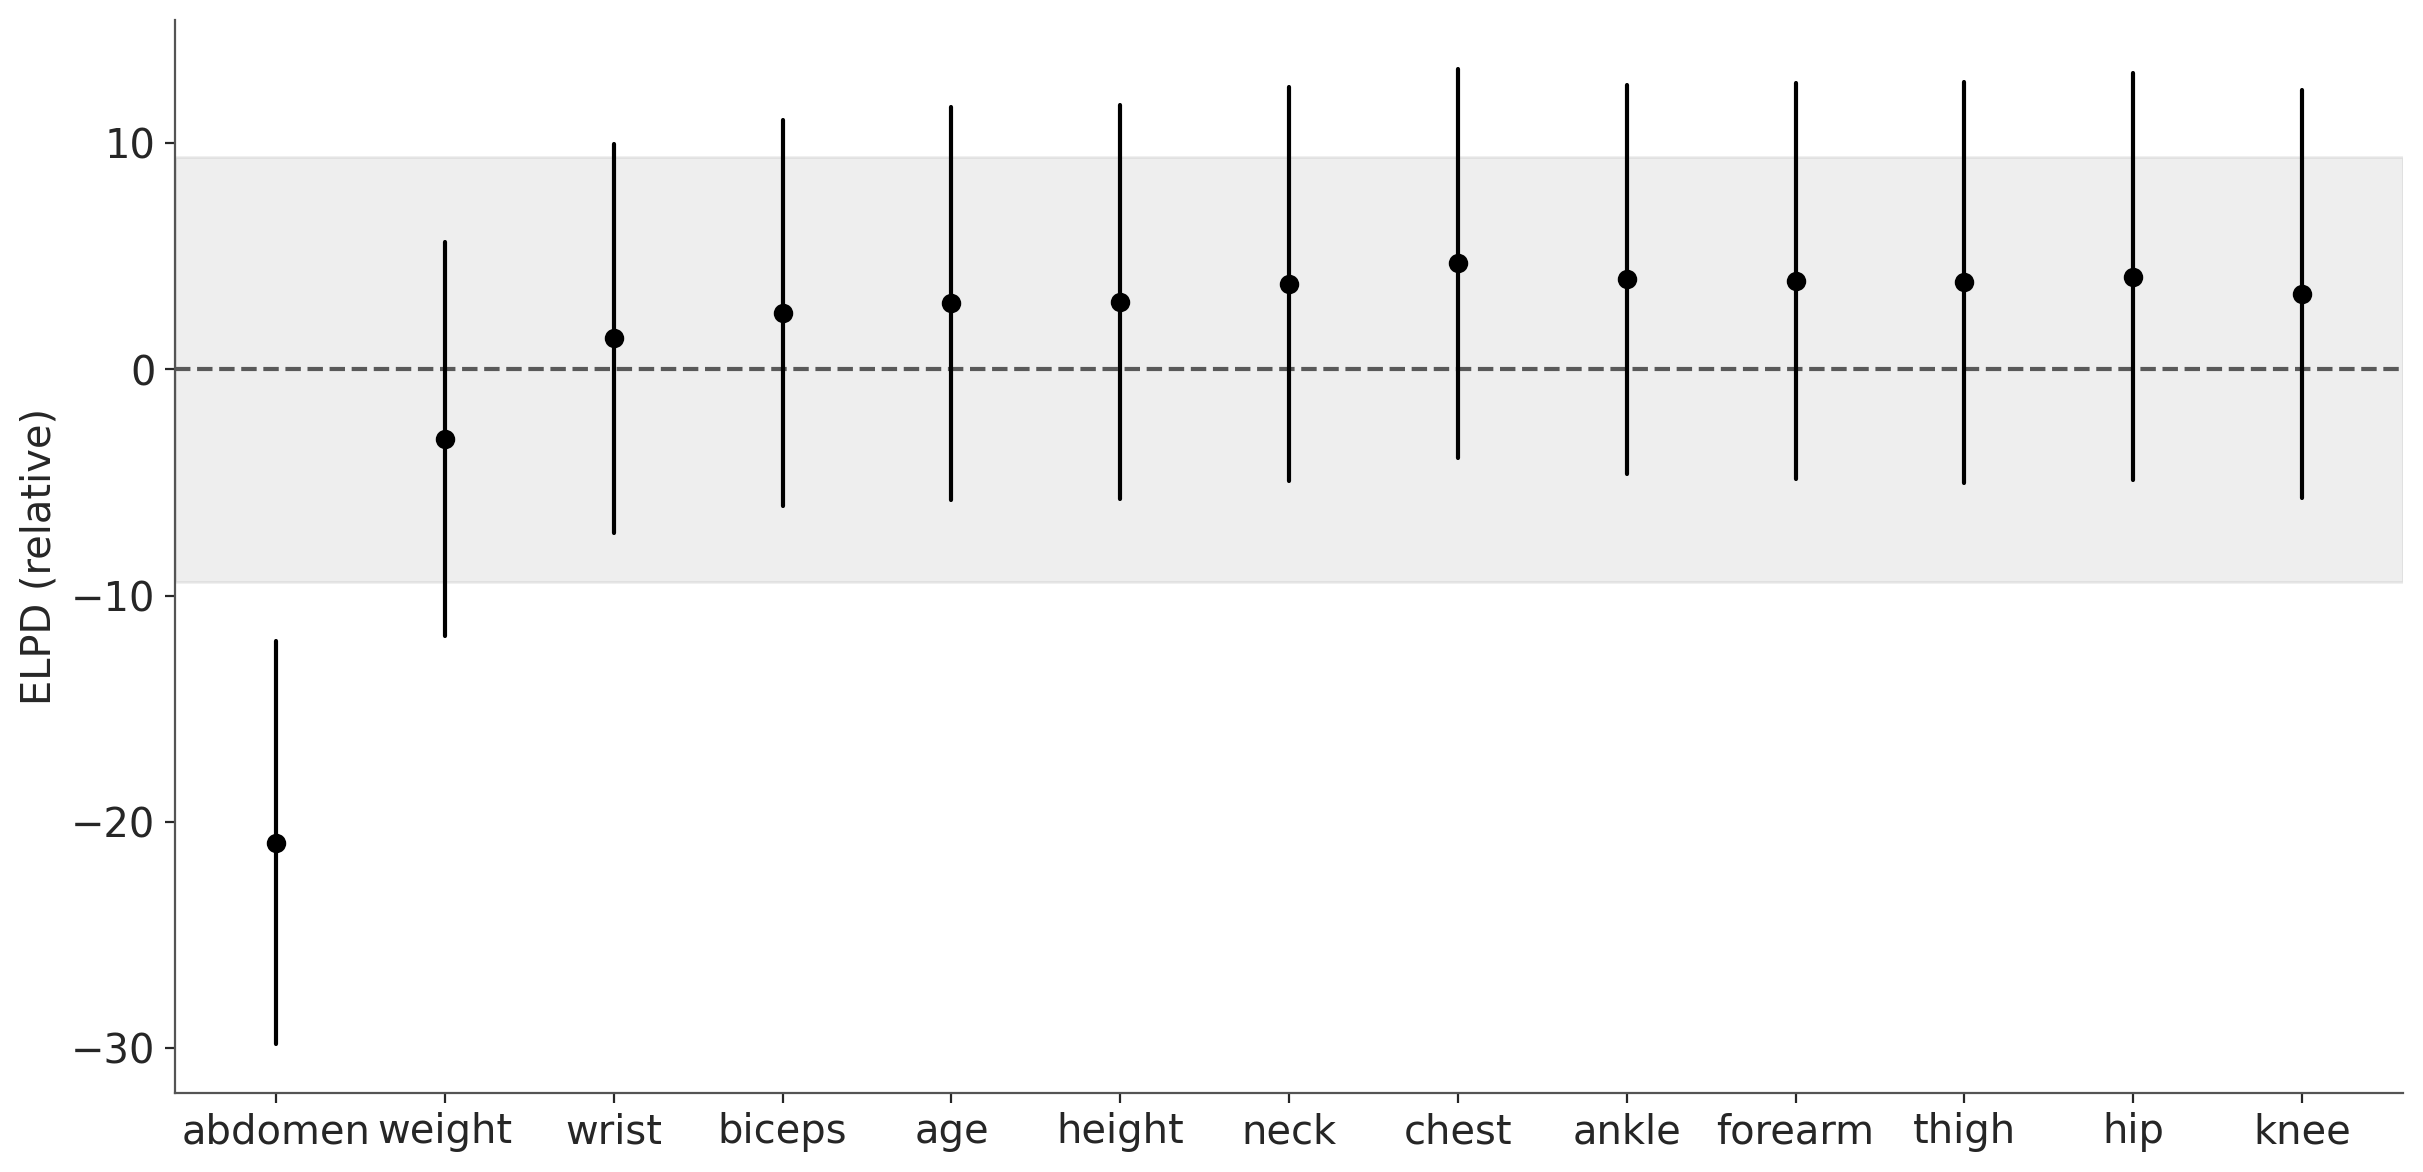

In [6]:
kpt.plot_compare(cmp_df);

From this plot we can see that the most relevant variable is `abdomen`, in the sense that if we were forced to pick a single variable, picking `abdomen` would be the one that would make the predictions most similar to the reference model. But the difference of ELPD between the submodel `abdomen` and the reference model is large, so we may want to include more variables. If we include two variables `abdomen` and `weight`, or maybe tree `abdomen`, `weight` and `wrist` we should get a model that is statistically indistinguishable from the reference model (under the ELPD metric). 

The error bars give us an idea of the uncertainty of the ELPD estimate. This is telling us that if we repeat the experiment many times (or computation using a different seed or bootstrap the data), we should expect to get `abdomen` as the most relevant variable almost 100% of the time. For the second position, `weight` and `wrist` are the most likely contenders, though other variables could occasionally take that spot. Similarly, from the previous figure it would not be meaningful to claim that `forearm` is more relevant than `hip`.

### Automated selection of submodels

`plot_compare` provides very useful information in a visual way. However, sometimes we may want a more automated way to select the submodels. This can be done by calling the `select` method. If we use the `select` method for our example, we see that the selected submodel is the one with `abdomen` and `weight` (plus the intercept, that is always included).

In [7]:
selected_submodel = ppi.select()
selected_submodel

['Intercept', 'abdomen', 'weight']

When using the `select` method we have two options: `mean` (the default one) and `se`. `mean` selects the smallest submodel with an ELPD that is within 4 units of the reference model. The "se" methods selects the smallest submodel with an ELPD that is within one standard error of the reference model. Both criteria behave similarly. Usually, the `mean` criterion results in more stable selection, and selects larger and better-performing submodels {cite}`Mclatchie_2024`.


As usual statistical methods should help us make decisions, but they should not make decisions for us. When deciding which variables to include in the model we may prefer an order that is slightly different from the one provided by Kulprit, the decision could be based on extra information that is not included in the model. For example, after discussion with domain experts or coworkers, we might determine that weighing patients is too cumbersome and decide to include only `abdomen` and `wrist` measurements.

### Exploring the projected posterior

Usually for the purpose of variable selection we do not care about the projections themselves, as they are just an intermediate step to perform variable selection. Nevertheless, it's possible to use and explore the projected posterior. The `plot_forest` function allow us to plot the posterior marginals of the submodels (and optionally the reference model too). 

In the following figure we can see that the posterior densities of the reference model and the largest submodel (i.e. the reference model projected onto itself) are very similar.

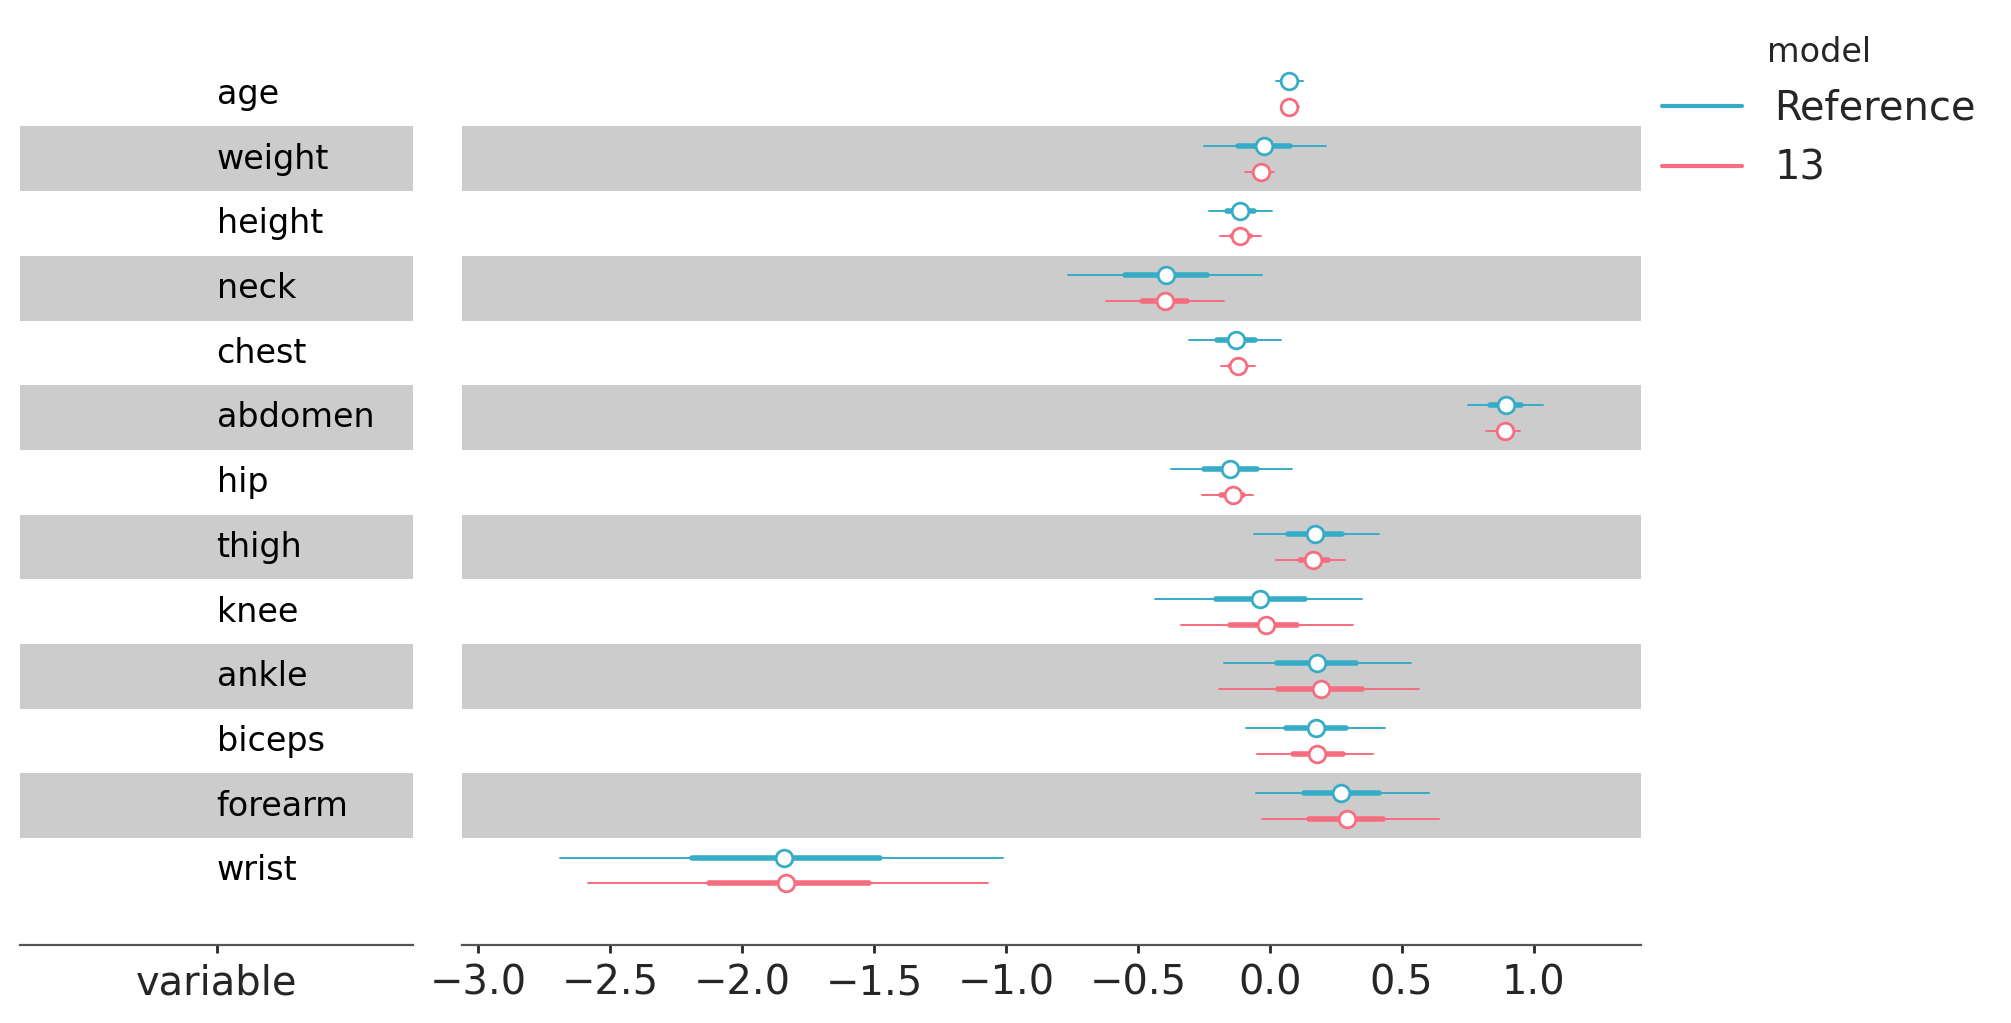

In [8]:
kpt.plot_forest(ppi,
                   submodels=[13],
                   include_reference=True,
                   figure_kwargs={"figsize": (10, 5)},
                  );

Below we can see the projection for the submodel of size 2, `abdomen + weight`. This time using the `plot_dist` function.

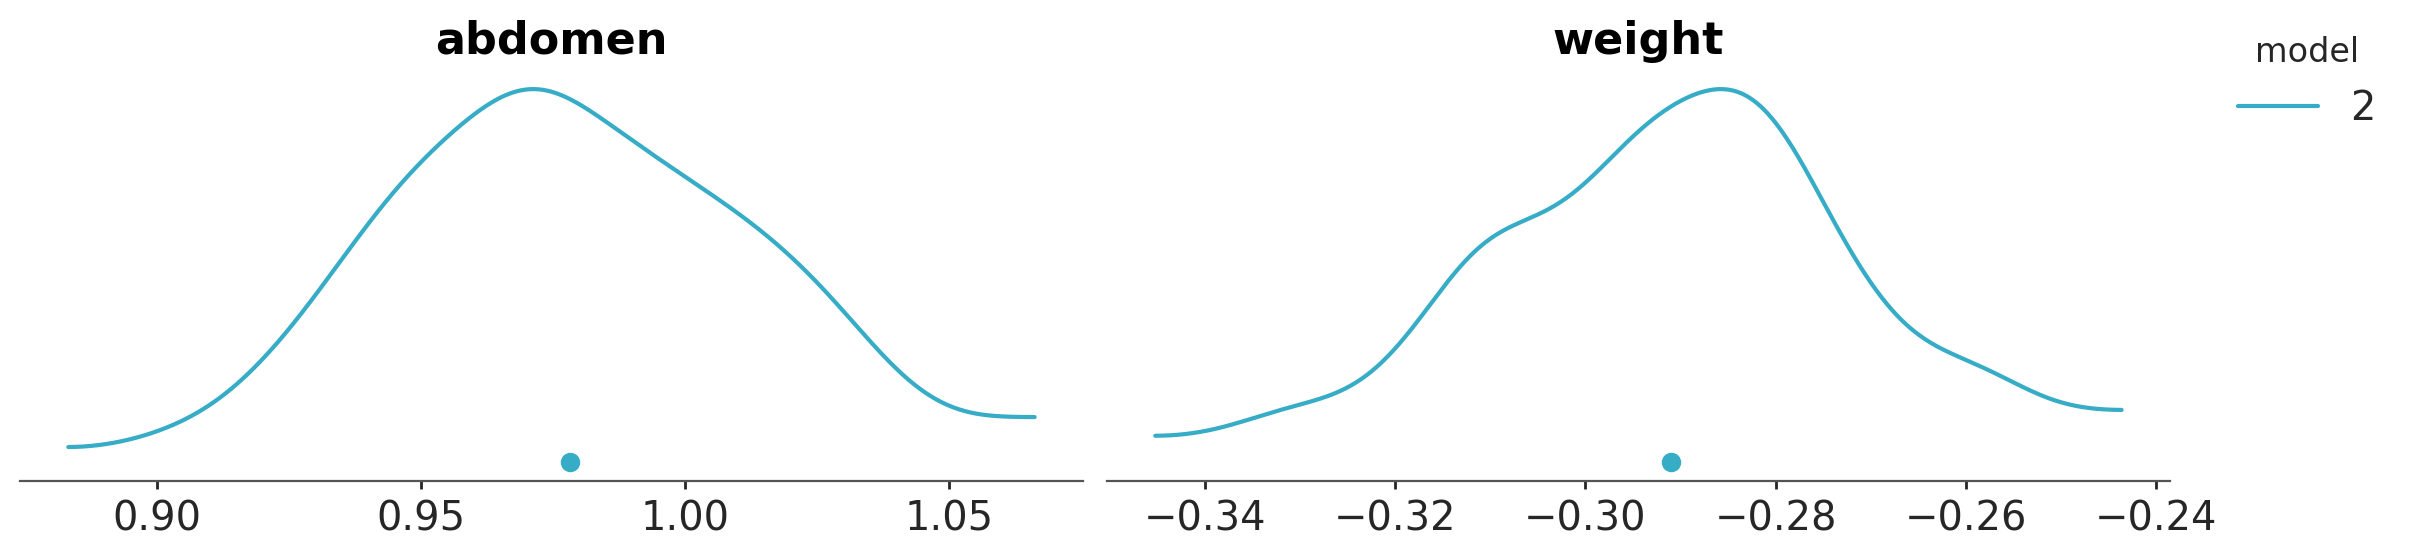

In [9]:
kpt.plot_dist(ppi,
              submodels=[selected_submodel.size],
              );

The plotting functions in Kulprit are thin wrappers around [ArviZ](https://arviz-plots.readthedocs.io/en/latest/)'s plotting function with the same names. Kulprit may perform some preproccessing or use different defaults to better suit the purpose of variable selection.

## Bikes

In [10]:
bikes = pd.read_csv("bikes.csv")

We expect rentals to go up in the morning and in the evening, and to go down in the middle of the day and at night. A linear model may have difficulties to handle this kind of non-linear behavior. To better model the effect of the variable `hour` we could transform it into a set of dummy variables like 
 

```python
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)
bikes.drop(columns="hour", inplace=True)
``` 

or we could use a more flexible model like splines (that is also a kind of data transformation). Let's try the latter.

In [11]:
knots = range(1, 22, 5)
priors = {
    "alpha": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("count ~ bs(hour, knots=knots, intercept=True) + " + " + ".join(bikes.columns.drop(["count", "hour"])),
                  bikes,
                  family="negativebinomial",
                  priors=priors)

model.set_alias({"bs(hour, knots=knots, intercept=True)": "bs_hour"})
idata = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs_hour, season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


### Performing the projection

As previously, mentioned before perfoming variable selection, we need to be sure we trust the reference model. This includes checking MCMC diagnostics and other evaluations like posterior predictive checks. We only skip this step for brevity in these examples.

If you forget to compute the log_likelihood when fitting the model, Kulprit will emit a warning and will compute it for you.

In [ ]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projection/arviz_io.py:80: UserWarning: log_likelihood group is missing from idata, it will be computed.
To avoid this message, please run Bambi's fit method with the option idata_kwargs={'log_likelihood': True}
  warnings.warn(


### Inspecting the results

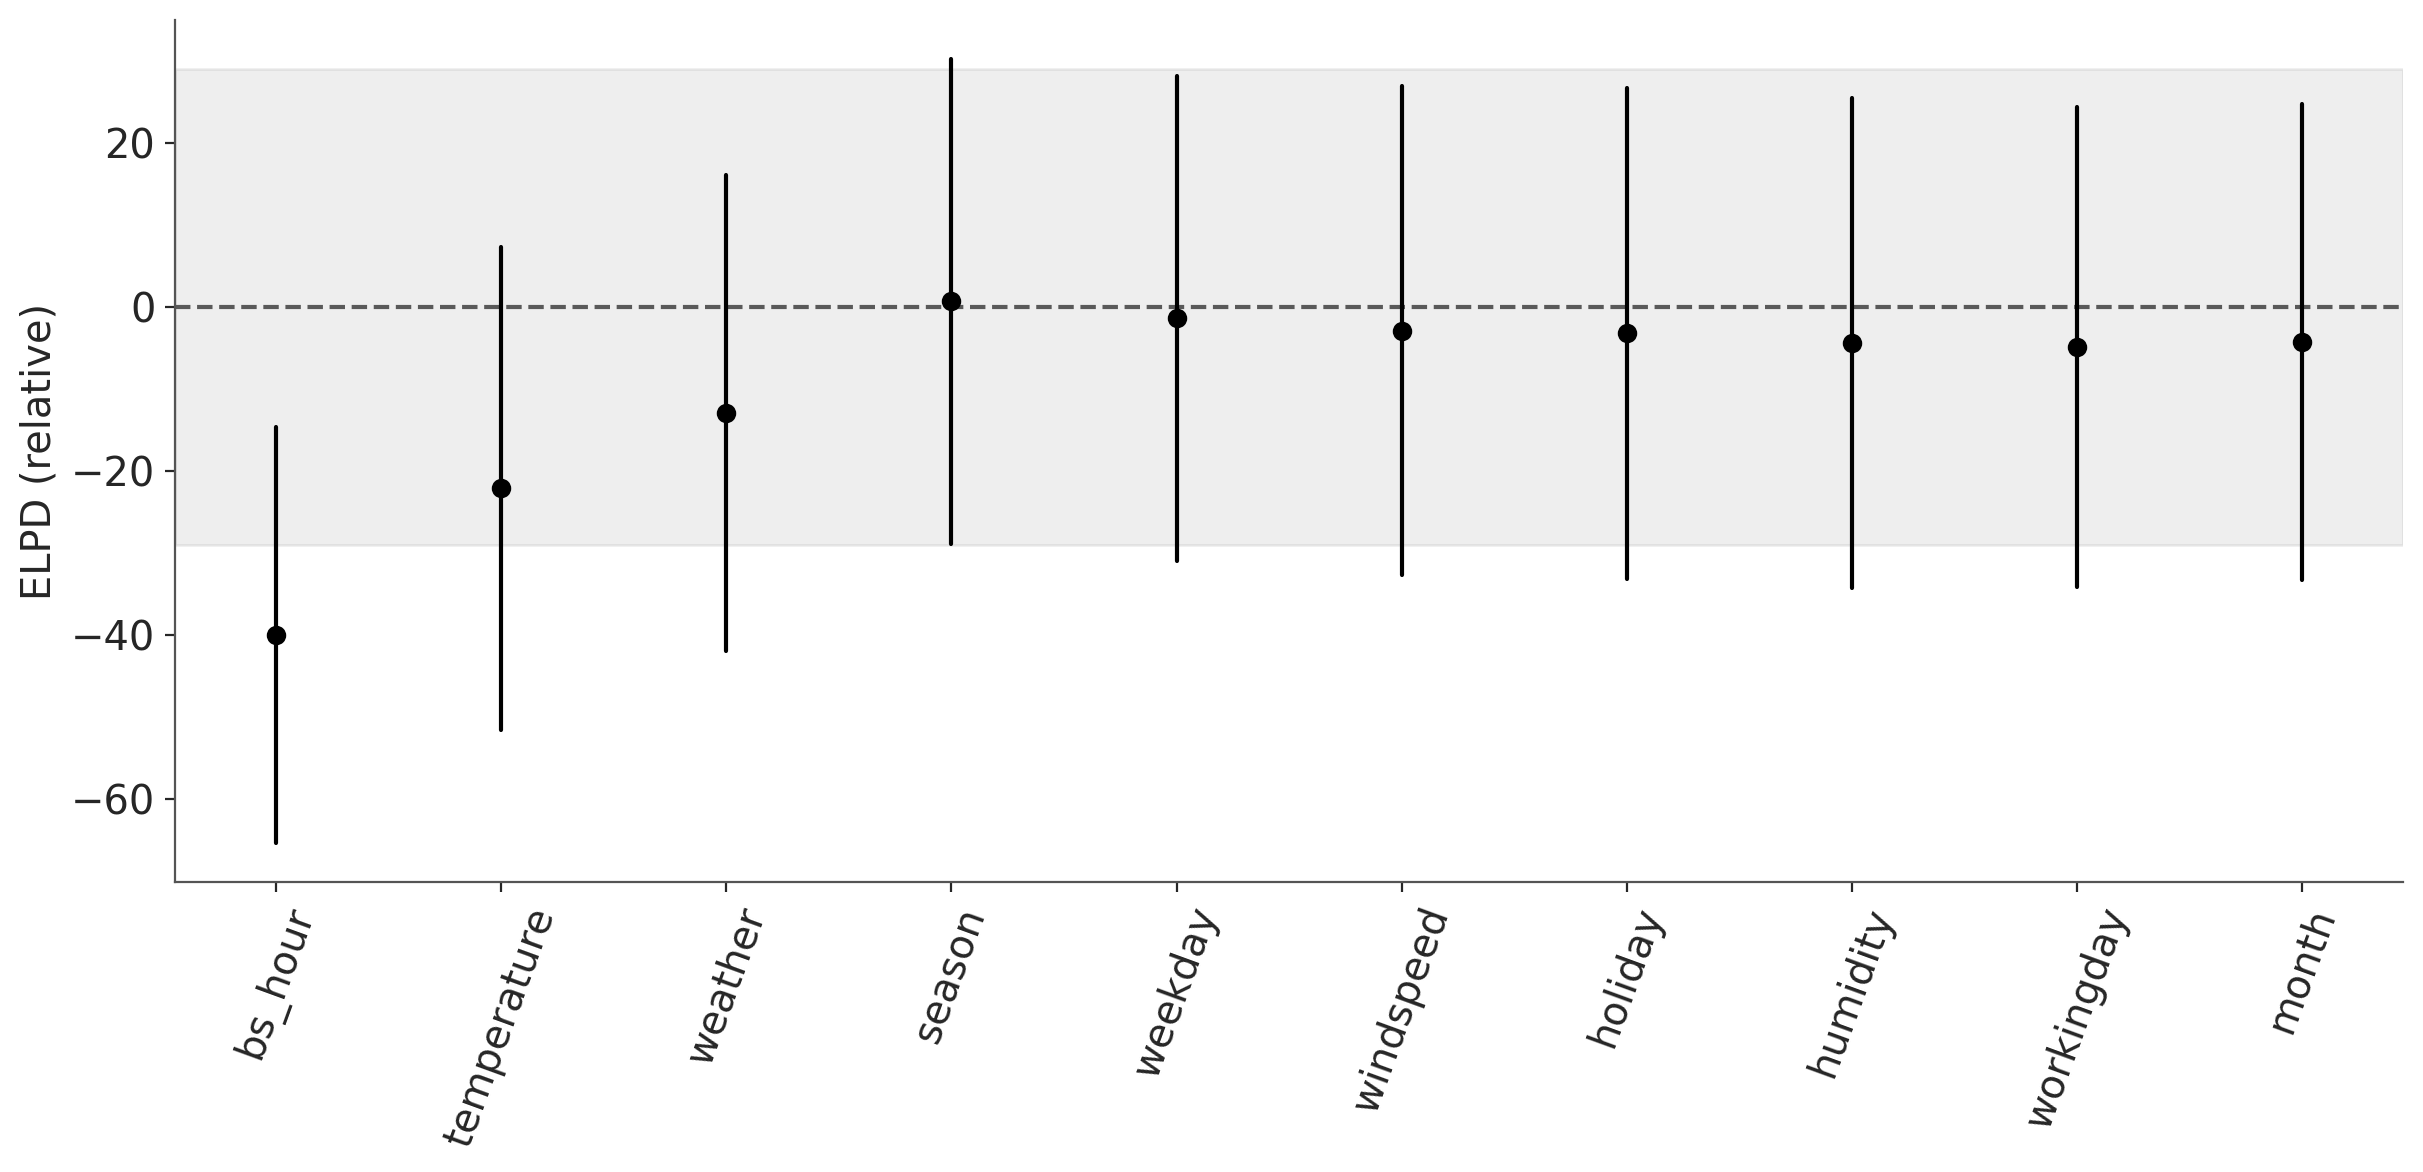

In [ ]:
kpt.plot_compare(ppi.compare(min_model_size=1),
                 visuals={"ticklabels":{"rotation": 70}},                 
                 );

We can see that `hour` is the most important variable in the model, followed by `temperature`. 

### Early stopping

We may want to stop the projection earlier, specially when we have a lot of variables. We can do this by setting the `early_stop` argument (defaults to None). The available options are:

* The strings `mean` or `se`, their meaning is the same as in the `select` method. 
* An integer, indicating the maximum model size to project.

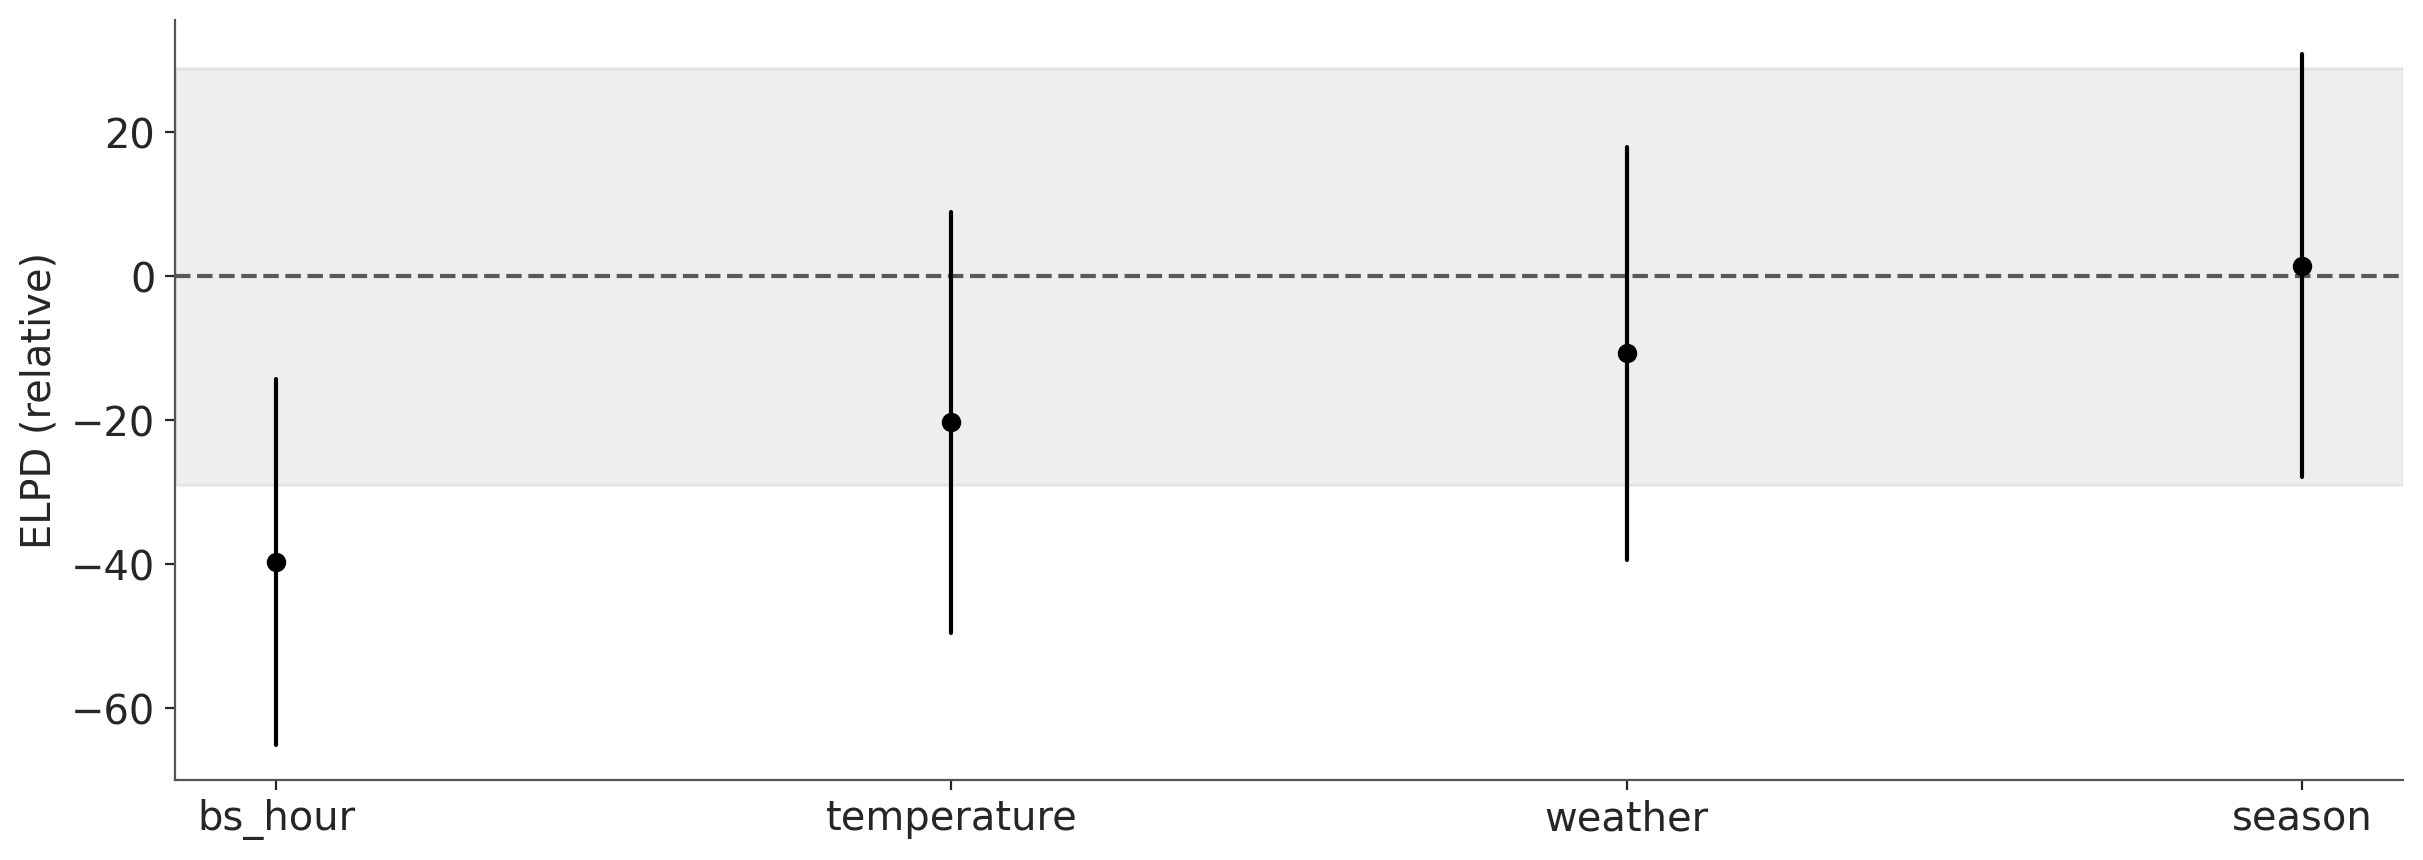

In [ ]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project(early_stop="mean")
kpt.plot_compare(ppi.compare(min_model_size=1));

## Speeding up the projection

There are a few options we can use to speed up the projection. It's important to note that all of them will reduce the accuracy of the results. Still, a faster projection could be useful when we have numerous variables, and we want to perform a preliminary analysis. 

To better understand the options we have we need to understand how Kulprit works. You can read the [overview](https://kulprit.readthedocs.io/en/latest/examples/overview.html) for details, but in short, Kulprit performs a search over the terms in the model to find the best submodels for each size, and then it evaluates the performance of each selected submodel. The evaluation step is done by projecting each selected submodel and then computing the ELPD (using PSIS-LOO-CV method) {cite:t}`Vehtari_2017, Vehtari_2024`, the result of this evaluation step is what you see when calling `compare` and `plot_compare`. 

To speed up the search step Kulprit uses a clustering algorithm to group the posterior predictive samples from the reference model. The number of clusters can be controlled using the `num_clusters` argument. A lower value will speed up the computation, but it will also reduce the accuracy of the search. The default value is 20, but for a quick analysis, a lower value like 10 or even 5 could be acceptable.

During the evaluation step, Kulprit don't use the clusters, instead it uses a higher number of posterior predictive samples. We can control this using the `num_samples` argument, which defaults to 400. A lower value like 100 could still provide reasonable results.

Another option is to change the search method. By default Kulprit uses a forward search (`method="forward"`), but we can also use lasso (`method="L1"`). This is faster than the default because no projection is done during the search, instead Kulprit performs a lasso search over the terms, and the projection is done only for the selected submodels. The downside is that the search step is less accurate as we loose the benefit of the projection during the search. 

Additionally, the argument `user_terms` can be used to provide the list of terms/submodels that we want to project. This is faster as no search is done. This can be used if we want to use some other method of search not yet implemented in Kulprit (see for example [PyMC-BART](https://arviz-devs.github.io/EABM/Chapters/Variable_selection.html#combining-pymc-bart-and-kulprit)).

## References
```{bibliography}
:style: unsrt
```